In [1]:
import os
os.chdir('../../stylegan2-ada-pytorch')

In [2]:
import numpy as np
import pickle
import torch
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from IPython.utils import io
import PIL.Image
from tqdm import tqdm
from glob import glob

# Imports for the projection function
import dnnlib
import legacy
from time import perf_counter
from projector import project

In [3]:
import platform
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()

In [4]:
try:
    if torch.cuda.is_available():
        DEVICE = 'cuda'
    elif torch.backends.mps.is_available():
        DEVICE = 'mps'
    else:
        DEVICE = 'cpu'
except:
    if torch.cuda.is_available():
        DEVICE = 'cuda'
    else:
        DEVICE = 'cpu'
print(f"Using {DEVICE} as device")

Using cpu as device


/pfs/work7/workspace/scratch/tu_zxmav84-thesis/miniconda3/envs/thesis/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


### Import Model

In [5]:
# Load model architecture
experiment_name = "00005-stylegan2_ada_images-mirror-auto2-kimg5000-resumeffhq512"
experiment_path = f"{DATA_PATH}/Models/Stylegan2_Ada/Experiments/{experiment_name}/"
model_name = "network-snapshot-001200.pkl"
model_path = experiment_path + model_name
with open(model_path, 'rb') as f:
    architecture = pickle.load(f)
    G = architecture['G_ema'].to(DEVICE)  # torch.nn.Module 
    D = architecture['D'].to(DEVICE)

### Test Random Generation

In [6]:
def generate_random():
    z = torch.randn([1, G.z_dim]).to(DEVICE)    # latent codes
    c = None                                # class labels (not used in this example)
    img = G(z, c,  force_fp32=True) 

    img_perm = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    output = PIL.Image.fromarray(img_perm[0].cpu().numpy(), 'RGB')
    return output

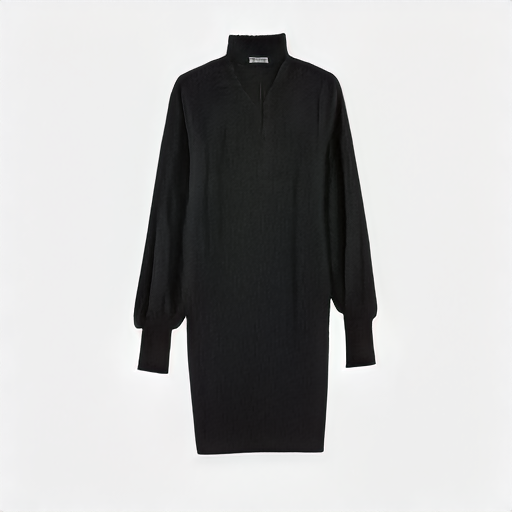

In [7]:
generate_random()

In [8]:
num_samples = 32
images = [generate_random() for i in tqdm(range(num_samples))]

100%|██████████| 32/32 [00:54<00:00,  1.72s/it]


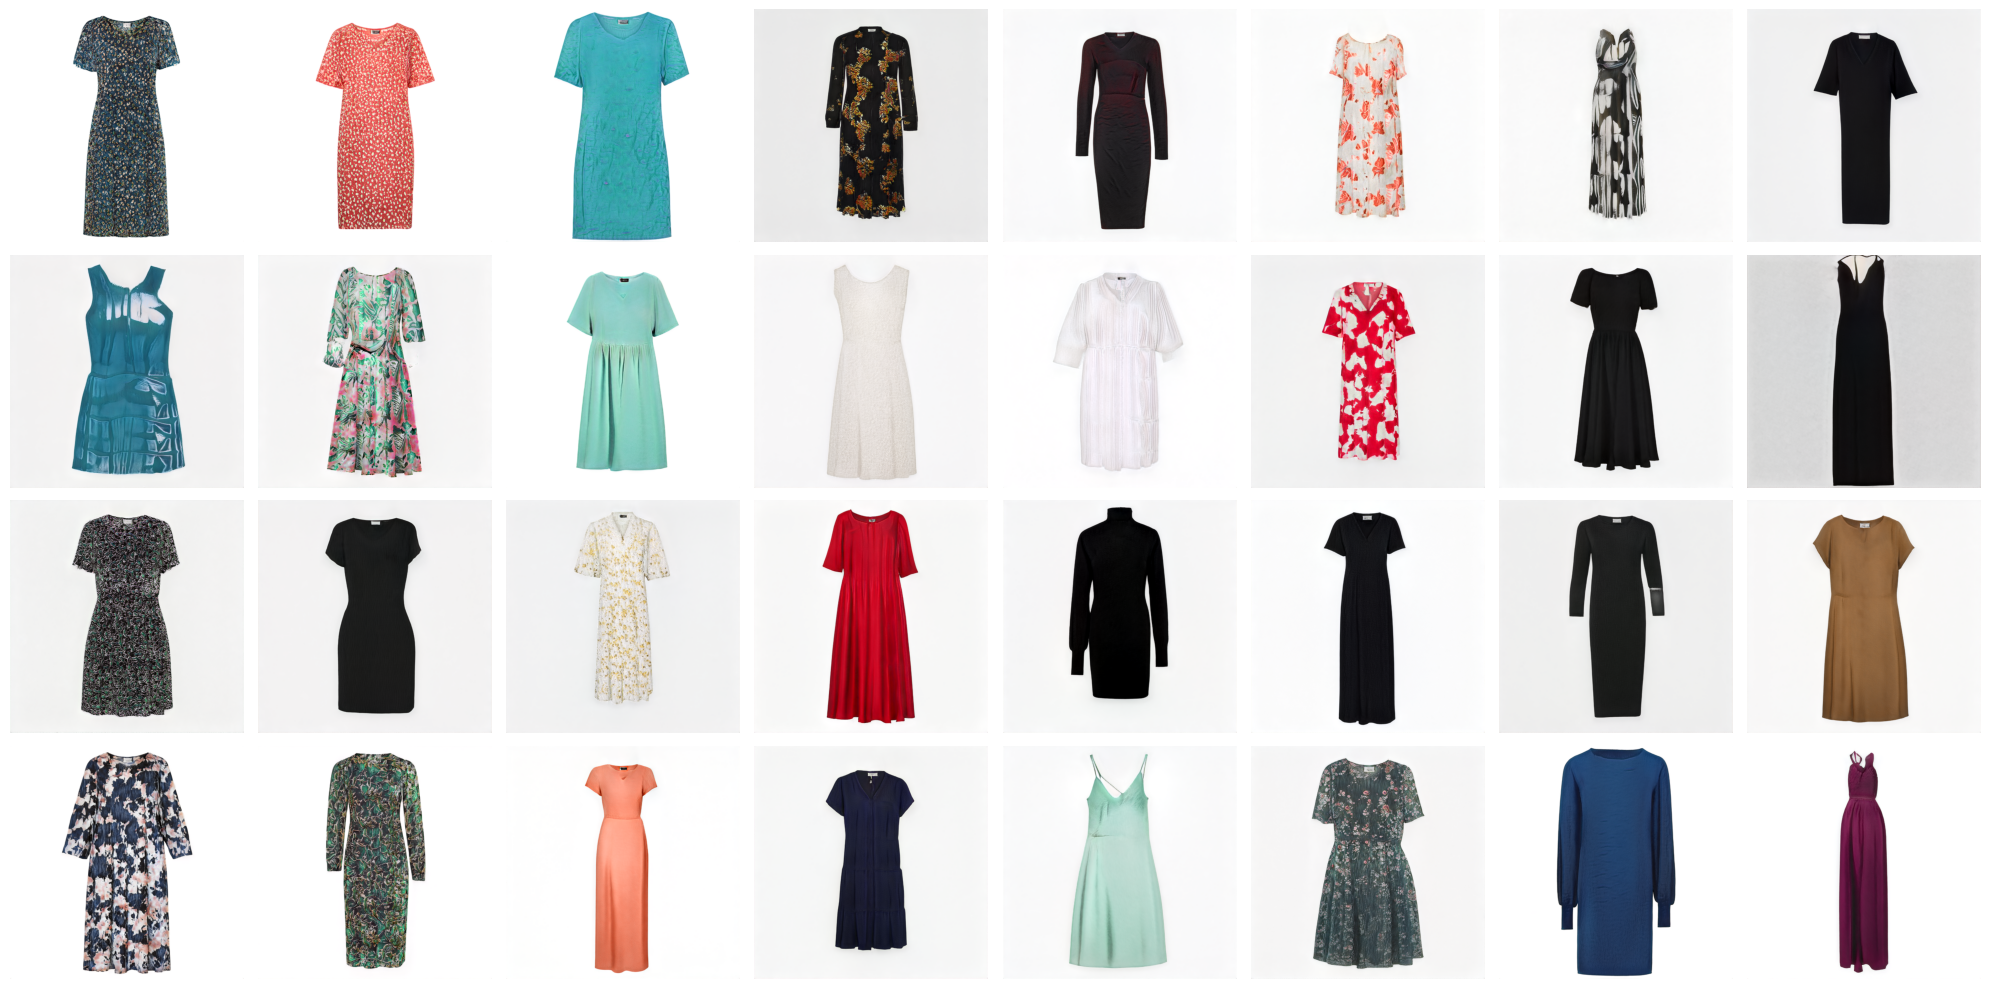

In [9]:
fig, axes = plt.subplots(4,8, figsize = (20,10))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.axis('off')
fig.tight_layout()
plt.show()

### Test Interpolation

In [ ]:
def get_interpolations(seed1, seed2, num_intermediates = 10):
    torch.manual_seed(seed1)
    z1 = torch.randn([1, G.z_dim]).to(DEVICE)
    w1 = G.mapping(z1, c)
    torch.manual_seed(seed2)
    z2 = torch.randn([1, G.z_dim]).to(DEVICE)
    w2 = G.mapping(z2, c)

    # Linearly interpolate between w1 and w2
    interpolated_tensors = []
    for i in range(num_intermediates + 2):  # including w1 and w2
        alpha = i / (num_intermediates + 1)
        interpolated_tensor = torch.lerp(w1, w2, alpha)
        interpolated_tensors.append(interpolated_tensor)

    # Generate images
    imgs = []
    for tensor in tqdm(interpolated_tensors, desc='Generating images'):
        img = G.synthesis(tensor, noise_mode='const')
        img_perm = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
        imgs.append(PIL.Image.fromarray(img_perm[0].cpu().numpy(), 'RGB'))
    
    return imgs

In [ ]:
seed1 = 903845
seed2 = 345468
num_intermediates = 10

imgs = get_interpolations(seed1, seed2, num_intermediates=num_intermediates)

def show_image(idx):
    plt.figure(figsize=(8, 8))
    plt.imshow(imgs[idx])
    plt.axis('off')
    plt.show()

num_images = len(imgs)
interact(show_image, idx=IntSlider(min=0, max=num_images-1, step=1, value=0))
plt.show()

### Test Reconstruction

1. Choose random original image
2. Project image into w-space
3. Generate new image from w-space
4. Compare original and generated image

In [ ]:
def run_projection(
    network_pkl: str,
    target_fname: str,
    seed:int = 42,
    num_steps:int = 1000, 
    silent = True):
    
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Load networks.
    print('Loading networks from "%s"...' % network_pkl)
    device = torch.device('cuda')
    with dnnlib.util.open_url(network_pkl) as fp:
        G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

    # Load target image.
    target_pil = PIL.Image.open(target_fname).convert('RGB')
    w, h = target_pil.size
    s = min(w, h)
    target_pil = target_pil.crop(((w - s) // 2, (h - s) // 2, (w + s) // 2, (h + s) // 2))
    target_pil = target_pil.resize((G.img_resolution, G.img_resolution), PIL.Image.LANCZOS)
    target_uint8 = np.array(target_pil, dtype=np.uint8)

    # Optimize projection.
    start_time = perf_counter()
    projected_w_steps = project(
        G,
        target=torch.tensor(target_uint8.transpose([2, 0, 1]), device=device), # pylint: disable=not-callable
        num_steps=num_steps,
        device=device,
        verbose=True
    )
    print (f'Elapsed: {(perf_counter()-start_time):.1f} s')

    # Save final projected frame and W vector.
    projected_w = projected_w_steps[-1]
    synth_image = G.synthesis(projected_w.unsqueeze(0), noise_mode='const')
    synth_image_perm = (synth_image.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    synth_image = PIL.Image.fromarray(synth_image_perm[0].cpu().numpy(), 'RGB')

    
    return (projected_w, target_pil, synth_image)

In [ ]:
NUM_EXAMPLES = 20
NUM_STEPS = 1000

orig_images = glob('../../Data.nosync/Zalando_Germany_Dataset/dresses/images/stylegan2_ada_images/*/*.png')
network = model_path


reconstructed_imgs = []
for i in tqdm(range(NUM_EXAMPLES)):
    np.random.seed()
    orig_path = np.random.choice(orig_images)
    with io.capture_output() as captured:
        projected_w, target_pil, synth_image = run_projection(network_pkl=model_path, target_fname=orig_path, num_steps=NUM_STEPS);
    reconstructed_imgs.append((projected_w, target_pil, synth_image))

In [ ]:
# Plot the images
fig, axs = plt.subplots(NUM_EXAMPLES, 2, figsize=(10, NUM_EXAMPLES*2))
for i, (_, orig_img, projected_img) in enumerate(reconstructed_imgs):
    axs[i, 0].imshow(orig_img)
    axs[i, 0].axis('off')
    axs[i, 1].imshow(projected_img)
    axs[i, 1].axis('off')
fig.tight_layout()